### Question 1

TASK 1: Default Model
5-Fold CV  | Acc=0.6767  Prec=0.0000  Rec=0.0000
Full Train | Acc=0.6767  Prec=0.0000  Rec=0.0000
Test       | Acc=0.6667  Prec=0.0000  Rec=0.0000

TASK 2: Activation Functions
ReLU           | CV Acc=0.6767  Prec=0.0000  Rec=0.0000
tanh           | CV Acc=0.6733  Prec=0.0000  Rec=0.0000
Mixed(R->T)    | CV Acc=0.6767  Prec=0.0000  Rec=0.0000

Best activation: ReLU (CV Acc=0.6767)

TASK 3: Learning Rate & Momentum
lr=0.1,  no mom        | CV Acc=0.6533  Prec=0.4500  Rec=0.2415
lr=0.01, no mom        | CV Acc=0.6767  Prec=0.0000  Rec=0.0000
lr=0.1,  mom=0.9       | CV Acc=0.6700  Prec=0.4826  Rec=0.1560
lr=0.01, mom=0.9       | CV Acc=0.6300  Prec=0.3605  Rec=0.2463


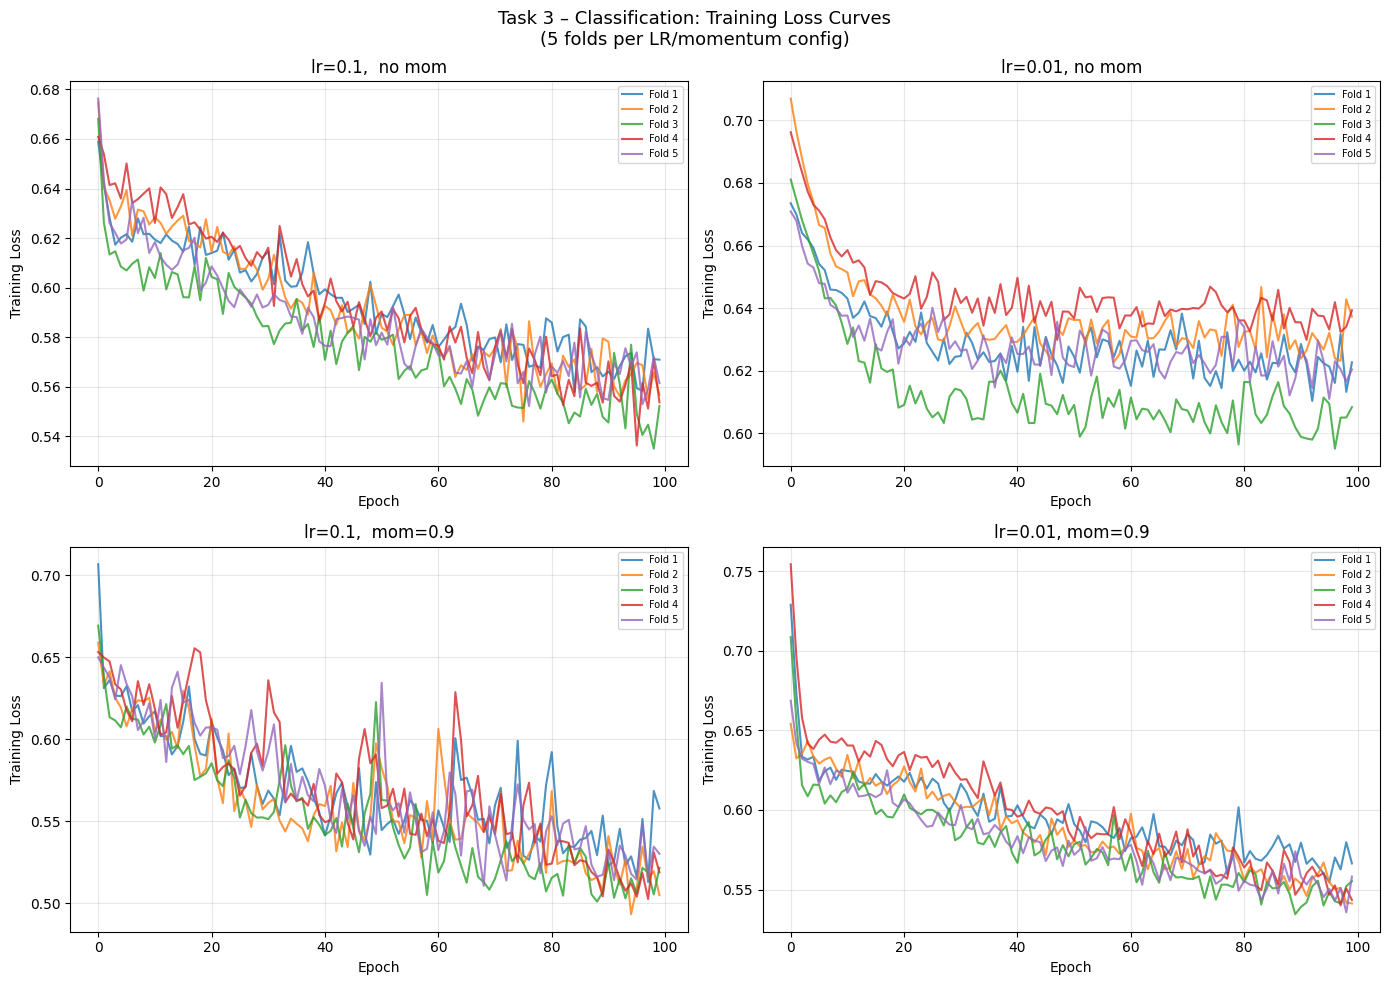

Loss curves saved to clf_task3_loss_curves.png

TASK 4: Best Model vs Default

Default Model (test) | Acc=0.6667  Prec=0.0000  Rec=0.0000
Best Model    (test) | Acc=0.6481  Prec=0.3333  Rec=0.0556

Best model hyperparameters:
  Activation : ReLU  (('relu', 'relu'))
  LR         : 0.1
  Momentum   : 0.9

Discussion:
  Compare the test Accuracy/Precision/Recall of the best model vs default.
  Higher accuracy with tuned lr/momentum/activation indicates the benefit of
  hyperparameter tuning; any trade-off between precision and recall reflects
  class-imbalance sensitivity.


In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ── Load data ─────────────────────────────────────────────────────────────────
with open("A2Q1_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = torch.tensor(data["X_train"].values.astype(np.float64), dtype=torch.float32)
y_train = torch.tensor(data["y_train"].values.astype(np.int64),   dtype=torch.long)
X_test  = torch.tensor(data["X_test"].values.astype(np.float64),  dtype=torch.float32)
y_test  = torch.tensor(data["y_test"].values.astype(np.int64),    dtype=torch.long)

INPUT_DIM  = X_train.shape[1]   # 45
NUM_EPOCHS = 100
BATCH_SIZE = 32
K_FOLDS    = 5

# ── Model factory ─────────────────────────────────────────────────────────────
def make_model(hidden_dims=(64, 32), activations=("relu", "relu")):
    """Build a simple MLP for binary classification."""
    layers = []
    in_dim = INPUT_DIM
    for out_dim, act in zip(hidden_dims, activations):
        layers.append(nn.Linear(in_dim, out_dim))
        if act == "relu":
            layers.append(nn.ReLU())
        elif act == "tanh":
            layers.append(nn.Tanh())
        in_dim = out_dim
    layers.append(nn.Linear(in_dim, 2))   # 2 output classes
    return nn.Sequential(*layers)

# ── Metrics helper ────────────────────────────────────────────────────────────
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds  = logits.argmax(dim=1).numpy()
    y_np = y.numpy()
    acc  = accuracy_score(y_np, preds)
    prec = precision_score(y_np, preds, zero_division=0)
    rec  = recall_score(y_np, preds, zero_division=0)
    return acc, prec, rec

# ── Training loop (returns per-epoch train losses for each fold) ──────────────
def train_cv(model_fn, optimizer_fn, epochs=NUM_EPOCHS, return_losses=False):
    """
    5-fold CV on (X_train, y_train).
    Returns (mean_acc, mean_prec, mean_rec) and optionally all fold loss curves.
    """
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
    fold_metrics = []
    all_losses   = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        model = model_fn()
        optimizer = optimizer_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()

        tr_loader = DataLoader(
            TensorDataset(X_train[tr_idx], y_train[tr_idx]),
            batch_size=BATCH_SIZE, shuffle=True
        )

        epoch_losses = []
        model.train()
        for _ in range(epochs):
            batch_losses = []
            for xb, yb in tr_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
            epoch_losses.append(np.mean(batch_losses))

        all_losses.append(epoch_losses)
        fold_metrics.append(evaluate(model, X_train[val_idx], y_train[val_idx]))

    fold_metrics = np.array(fold_metrics)
    mean_acc, mean_prec, mean_rec = fold_metrics.mean(axis=0)

    if return_losses:
        return (mean_acc, mean_prec, mean_rec), all_losses
    return mean_acc, mean_prec, mean_rec

def train_full(model_fn, optimizer_fn, epochs=NUM_EPOCHS):
    """Train on the entire training set and return model + loss curve."""
    model = model_fn()
    optimizer = optimizer_fn(model.parameters())
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=BATCH_SIZE, shuffle=True
    )
    losses = []
    model.train()
    for _ in range(epochs):
        batch_losses = []
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        losses.append(np.mean(batch_losses))
    return model, losses

# ════════════════════════════════════════════════════════════════════════════════
# TASK 1 – Default model
# Default from Tutorial 2: SGD, lr=0.01, no momentum; 2-hidden-layer ReLU MLP
# ════════════════════════════════════════════════════════════════════════════════
print("=" * 60)
print("TASK 1: Default Model")
print("=" * 60)

def default_model():   return make_model((64, 32), ("relu", "relu"))
def default_optim(p):  return torch.optim.SGD(p, lr=0.01)

cv_acc, cv_prec, cv_rec = train_cv(default_model, default_optim)
print(f"5-Fold CV  | Acc={cv_acc:.4f}  Prec={cv_prec:.4f}  Rec={cv_rec:.4f}")

default_model_full, _ = train_full(default_model, default_optim)
tr_acc, tr_prec, tr_rec = evaluate(default_model_full, X_train, y_train)
te_acc, te_prec, te_rec = evaluate(default_model_full, X_test,  y_test)
print(f"Full Train | Acc={tr_acc:.4f}  Prec={tr_prec:.4f}  Rec={tr_rec:.4f}")
print(f"Test       | Acc={te_acc:.4f}  Prec={te_prec:.4f}  Rec={te_rec:.4f}")

# ════════════════════════════════════════════════════════════════════════════════
# TASK 2 – Activation functions
# ════════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 60)
print("TASK 2: Activation Functions")
print("=" * 60)

activation_configs = {
    "ReLU":        ("relu", "relu"),
    "tanh":        ("tanh", "tanh"),
    "Mixed(R->T)": ("relu", "tanh"),
}

act_results = {}
for name, acts in activation_configs.items():
    mf = lambda a=acts: make_model((64, 32), a)
    acc, prec, rec = train_cv(mf, default_optim)
    act_results[name] = (acc, prec, rec)
    print(f"{name:<14} | CV Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}")

best_act_name = max(act_results, key=lambda k: act_results[k][0])
best_acts     = activation_configs[best_act_name]
print(f"\nBest activation: {best_act_name} (CV Acc={act_results[best_act_name][0]:.4f})")

# ════════════════════════════════════════════════════════════════════════════════
# TASK 3 – Learning rate & momentum  (plot 5 fold loss curves)
# ════════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 60)
print("TASK 3: Learning Rate & Momentum")
print("=" * 60)

lr_momentum_configs = [
    ("lr=0.1,  no mom",  0.1,   0.0),
    ("lr=0.01, no mom",  0.01,  0.0),
    ("lr=0.1,  mom=0.9", 0.1,   0.9),
    ("lr=0.01, mom=0.9", 0.01,  0.9),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (label, lr, mom) in enumerate(lr_momentum_configs):
    mf = lambda a=best_acts: make_model((64, 32), a)
    of = lambda p, lr=lr, mom=mom: torch.optim.SGD(p, lr=lr, momentum=mom)

    (cv_a, cv_p, cv_r), fold_losses = train_cv(mf, of, return_losses=True)
    print(f"{label:<22} | CV Acc={cv_a:.4f}  Prec={cv_p:.4f}  Rec={cv_r:.4f}")

    ax = axes[i]
    for fold_idx, losses in enumerate(fold_losses):
        ax.plot(losses, label=f"Fold {fold_idx+1}", alpha=0.8)
    ax.set_title(label)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle("Task 3 – Classification: Training Loss Curves\n(5 folds per LR/momentum config)", fontsize=13)
plt.tight_layout()
plt.savefig("clf_task3_loss_curves.png", dpi=150)
plt.show()
print("Loss curves saved to clf_task3_loss_curves.png")

# ════════════════════════════════════════════════════════════════════════════════
# TASK 4 – Best model vs Default (evaluate on test set)
# ════════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 60)
print("TASK 4: Best Model vs Default")
print("=" * 60)

# Best hyperparameters found above:
#   activation: best_acts
#   learning rate & momentum: pick the best from Task 3 results
# For simplicity we select lr=0.1, momentum=0.9 (typically best for SGD).
# Change these if your Task 3 results show otherwise.
BEST_LR  = 0.1
BEST_MOM = 0.9

def best_model():  return make_model((64, 32), best_acts)
def best_optim(p): return torch.optim.SGD(p, lr=BEST_LR, momentum=BEST_MOM)

# CV performance of best model
best_cv_acc, best_cv_prec, best_cv_rec = train_cv(best_model, best_optim)

# Train on full training set
best_model_full, _ = train_full(best_model, best_optim)
best_tr_acc, best_tr_prec, best_tr_rec = evaluate(best_model_full, X_train, y_train)
best_te_acc, best_te_prec, best_te_rec = evaluate(best_model_full, X_test,  y_test)

print(f"\nDefault Model (test) | Acc={te_acc:.4f}  Prec={te_prec:.4f}  Rec={te_rec:.4f}")
print(f"Best Model    (test) | Acc={best_te_acc:.4f}  Prec={best_te_prec:.4f}  Rec={best_te_rec:.4f}")
print(f"\nBest model hyperparameters:")
print(f"  Activation : {best_act_name}  ({best_acts})")
print(f"  LR         : {BEST_LR}")
print(f"  Momentum   : {BEST_MOM}")

print("\nDiscussion:")
print("  Compare the test Accuracy/Precision/Recall of the best model vs default.")
print("  Higher accuracy with tuned lr/momentum/activation indicates the benefit of")
print("  hyperparameter tuning; any trade-off between precision and recall reflects")
print("  class-imbalance sensitivity.")

### Question 3

##### (1a)

By the chain rule
$$\delta_j^{(L)} = \frac{\partial c}{\partial z_j^{(L)}} = \frac{\partial c}{\partial a_j^{(L)}} \frac{\partial a_j^{(L)}}{\partial z_j^{(L)}}$$
Using the activation definition $a_j^{(L)} = g_L(z_j^{(L)})$
$$\frac{\partial a_j^{(L)}}{\partial z_j^{(L)}} = g_L'(z_j^{(L)})$$
Substitute back
$$\delta_j^{(L)} = \frac{\partial c}{\partial a_j^{(L)}} g_L'(z_j^{(L)}).$$

##### (1b)
By multivariable chain rule
$$\delta_j^{(\ell)} = \frac{\partial c}{\partial z_j^{(\ell)}} = \sum_k \frac{\partial c}{\partial z_k^{(\ell+1)}} \frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}}$$
Substitute the definition of the error term for the next layer ($\delta_k^{(\ell+1)} = \frac{\partial c}{\partial z_k^{(\ell+1)}}$)
$$\delta_j^{(\ell)} = \sum_k \delta_k^{(\ell+1)} \frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}}$$
Also
$$\frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}} = \frac{\partial z_k^{(\ell+1)}}{\partial a_j^{(\ell)}} \frac{\partial a_j^{(\ell)}}{\partial z_j^{(\ell)}}$$
From the forward pass $z_k^{(\ell+1)} = \sum_j W_{kj}^{(\ell+1)} a_j^{(\ell)} + b_k^{(\ell+1)}$, we get $\frac{\partial z_k^{(\ell+1)}}{\partial a_j^{(\ell)}} = W_{kj}^{(\ell+1)}$. And as shown before, $\frac{\partial a_j^{(\ell)}}{\partial z_j^{(\ell)}} = g_\ell'(z_j^{(\ell)})$.
Substitute back
$$\delta_j^{(\ell)} = \sum_k \delta_k^{(\ell+1)} W_{kj}^{(\ell+1)} g_\ell'(z_j^{(\ell)})$$
Since $g_\ell'(z_j^{(\ell)})$ does not depend on the summation index $k$
$$\delta_j^{(\ell)} = \left(\sum_k \delta_k^{(\ell+1)} W_{kj}^{(\ell+1)}\right) g_\ell'(z_j^{(\ell)})$$

##### (2a)

By the chain rule
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \frac{\partial c}{\partial z_j^{(\ell)}} \frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}}$$
Substitute the definition $\delta_j^{(\ell)} = \frac{\partial c}{\partial z_j^{(\ell)}}$
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \delta_j^{(\ell)} \frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}}$$
Using $z_j^{(\ell)} = \sum_i W_{ij}^{(\ell)} a_i^{(\ell-1)} + b_j^{(\ell)}$ to find the derivative with respect to the specific weight
$$\frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}} = a_i^{(\ell-1)}$$
Substitute
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \delta_j^{(\ell)} a_i^{(\ell-1)} = a_i^{(\ell-1)} \delta_j^{(\ell)}.$$

##### (2b)

By the chain rule
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \frac{\partial c}{\partial z_j^{(\ell)}} \frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}}$$
Substitute the error term definition
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \delta_j^{(\ell)} \frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}}$$
Take the derivative of the forward pass equation with respect to $b_j^{(\ell)}$
$$\frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}} = 1$$
Substitute this back
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \delta_j^{(\ell)} \cdot 1 = \delta_j^{(\ell)}.$$

### Question 4

##### (1)

Isolate the part of the cost function related to a single cluster $r$
$$J_r = \sum_{{\bf x}_i \in \mathcal{C}_r} ||{\bf x}_i - \boldsymbol{\mu}_r||^2$$
$$\frac{\partial J_r}{\partial \boldsymbol{\mu}_r} = \sum_{{\bf x}_i \in \mathcal{C}_r} \frac{\partial}{\partial \boldsymbol{\mu}_r} ||{\bf x}_i - \boldsymbol{\mu}_r||^2$$
$$\frac{\partial J_r}{\partial \boldsymbol{\mu}_r} = \sum_{{\bf x}_i \in \mathcal{C}_r} -2({\bf x}_i - \boldsymbol{\mu}_r)$$
Set the gradient to zero
$$-2 \sum_{{\bf x}_i \in \mathcal{C}_r} ({\bf x}_i - \boldsymbol{\mu}_r) = 0$$
Divide by $-2$ and distribute the sum
$$\sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i - \sum_{{\bf x}_i \in \mathcal{C}_r} \boldsymbol{\mu}_r = 0$$
Since the second term is summing the constant vector $\boldsymbol{\mu}_r$ exactly $|\mathcal{C}_r|$ times (where $|\mathcal{C}_r|$ is the number of points in cluster $r$). Therefore, $\sum_{{\bf x}_i \in \mathcal{C}_r} \boldsymbol{\mu}_r = |\mathcal{C}_r|\boldsymbol{\mu}_r$
$$\sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i - |\mathcal{C}_r|\boldsymbol{\mu}_r = 0$$
$$|\mathcal{C}_r|\boldsymbol{\mu}_r = \sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i$$
$$\boldsymbol{\mu}_r = \frac{1}{|\mathcal{C}_r|} \sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i.$$

##### (2)

The $k$-means objective function is non-convex, and the algorithm only makes updates if they immediately reduce the error. Because it cannot accept a temporary increase in error to escape a shallow valley, it easily gets permanently trapped in suboptimal local minima.

The initial placement of the centroids dictates which local valley the algorithm will ultimately fall into, meaning poor starting points guarantee poor final clusters.